In [ ]:
'''
In this module, we try to add several features we think can improve our model
1. Features related to Date and Time
2. Features based on Co-ordinates( Clustering)
3. Features to capture historical crimes and their rates
    a. Identifying top locations for specific crimes
    b. Checking crimes in the same cluster
'''

# 1. Features related to Date and Time

In [40]:
#### Importing Libraries and Modules
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

#### Importing imputed data
train = pd.read_csv('../data/imputed_train.csv')

In [41]:
train['incident_datetime'] = pd.to_datetime(train['incident_datetime'], errors='coerce')
train['weekday'] = train['incident_datetime'].dt.dayofweek
train['weekofyear'] = train['incident_datetime'].dt.weekofyear
train['hourofday'] = train['incident_datetime'].dt.hour
train["workhour"] = train["hourofday"].map(lambda x: 1 if x in range(9,17) else 0)
train["sunlight"] = train["hourofday"].map(lambda x: 1 if x in range(7,19) else 0)

##### Added several features such as weekday, week of the year, hour of the day and others from the datetime 

# 2. Features based on Co-ordinates( Clustering)

In [43]:
from sklearn.cluster import MiniBatchKMeans
### KNN cluster for lat and long
coords = np.vstack((train[['incident_cord_x', 'incident_cord_y']].values))
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=33, batch_size=10000).fit(coords[sample_ind])

### Applying cluster on training data
kmeans.predict(train[['incident_cord_x', 'incident_cord_y']])
train.loc[:, 'clustertype'] = kmeans.predict(train[['incident_cord_x', 'incident_cord_y']])

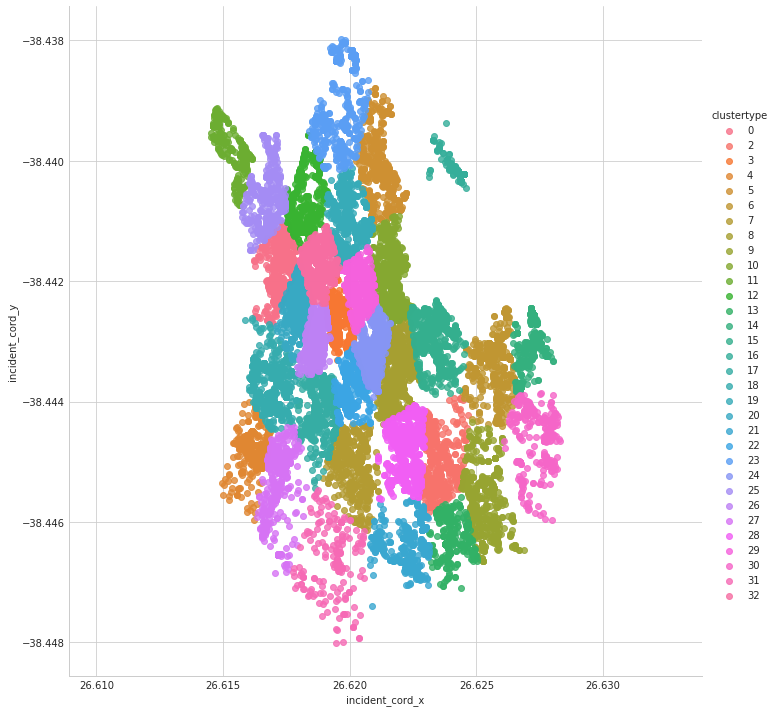

In [44]:
### Visualizing the clusters

sns.set_style("whitegrid")
## Scatterplot of the crimes
sns.lmplot(x="incident_cord_x", y="incident_cord_y",data = train[train['incident_cord_x']!=0.0],fit_reg=False,hue='clustertype',size=10)

# 3. Features to capture historical crimes and their rates

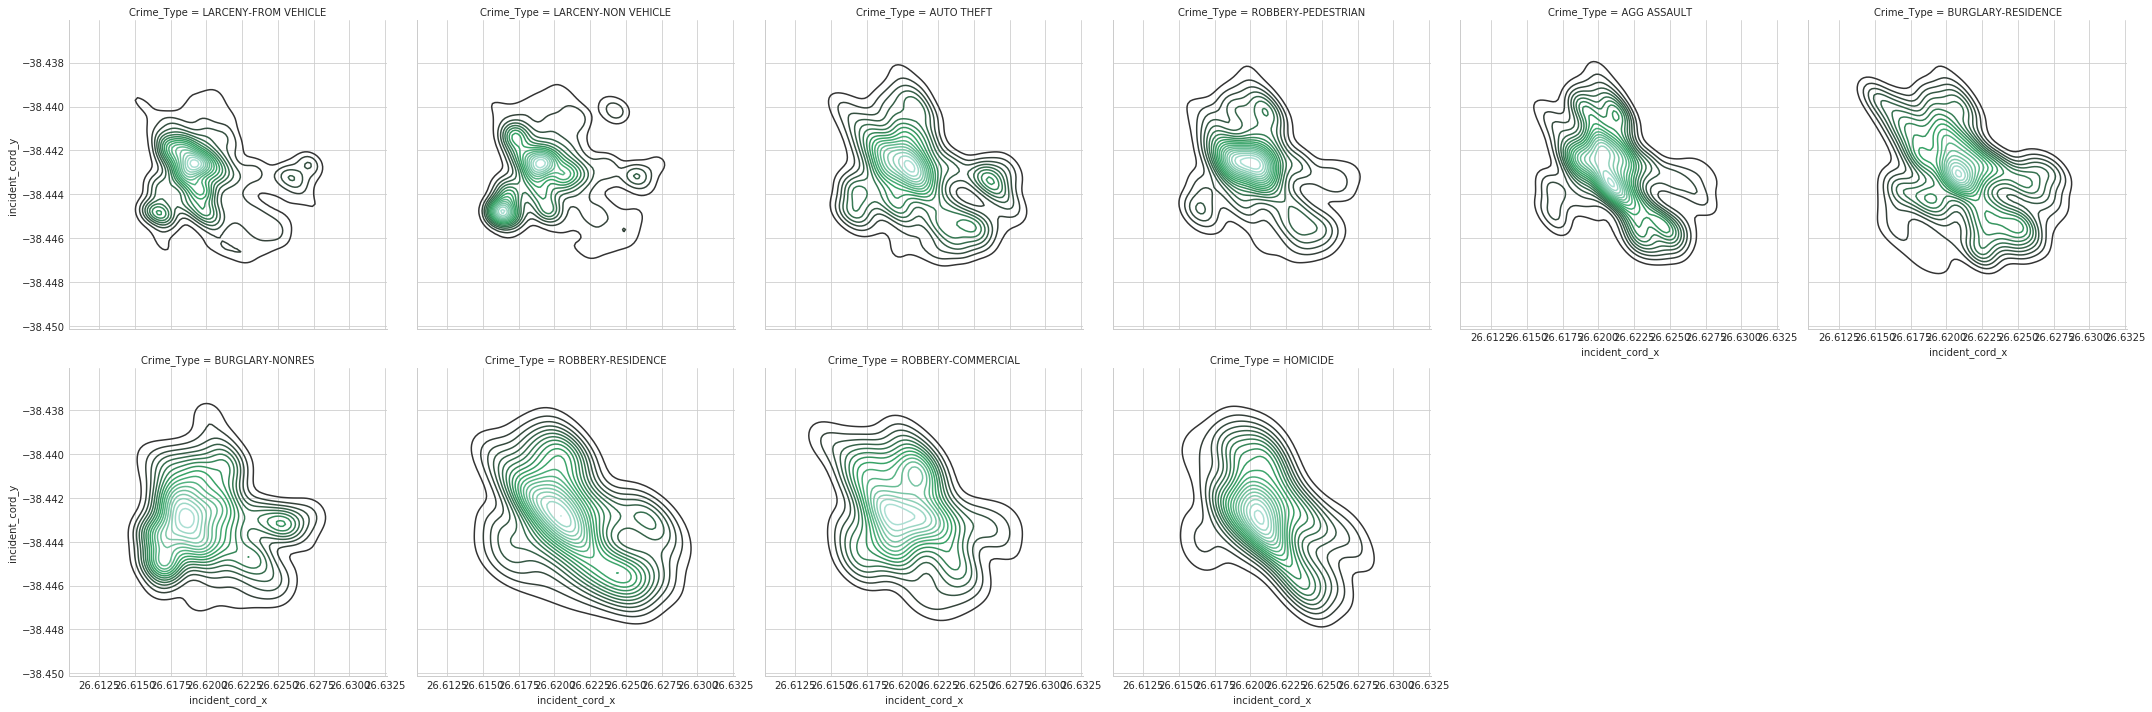

In [46]:
#Seaborn FacetGrid, split by crime Category
g= sns.FacetGrid(train[train['incident_cord_x']!=0.0], col="Crime_Type", col_wrap=6, size=5)
#Kernel Density Estimate plot
g.map(sns.kdeplot, "incident_cord_x", "incident_cord_y", n_levels =20)

##### The above plot shows how the different crimes have different densities across the co-ordinates. So it makes sense to tag several locations as 'Crime Hotspots' based on the crime density which can be extracted from the historical data.This was our motivation to include features that can tell about the crime rates(total crimes in that cluster compared to all crimes)


In [47]:
## Making a temp data frame with just category and clusters with Date as index"
df = train.copy()
df['incident_datetime'] = pd.to_datetime(df['incident_datetime'], errors='coerce')
df['Date']= df['incident_datetime'].dt.date
df = df[['Crime_Type','clustertype','Date']]
df['Crime_Type'] = df['Crime_Type'].astype('category')

f_df = pd.DataFrame()


crimes = list(df['Crime_Type'].unique())
for c in crimes:
#     print (c)
    pivot_df = pd.DataFrame()
    temp = df[df['Crime_Type']==c]
    pivot_df= pd.pivot_table(temp,index=["Date"],values=["clustertype"],
               columns=["clustertype"],aggfunc=[len],fill_value=0).reset_index()
    res ={}
    flattened = pd.DataFrame(pivot_df.to_records())
    for col in flattened.columns[2:]:
        cluster = int(col.split(",")[2].replace(")","").replace(" ","").lstrip())
        res[cluster] =sum(flattened[col])
        res['Crime_Type'] = c

    res_df = pd.DataFrame(res,index=[0])
    f_df = f_df.append(res_df)
f_df = f_df.set_index('Crime_Type')
f_df['Total'] = f_df.sum(axis=1)
f_df

,0,2,3,4,5,6,7,8,9,10,...,25,26,27,28,29,30,31,32,1,Total
Crime_Type,,,,,,,,,,,,,,,,,,,,,
LARCENY-FROM VEHICLE,443.0,219.0,600.0,318.0,130.0,316.0,525.0,193.0,187.0,227.0,...,119.0,665.0,361.0,188.0,319.0,104.0,95.0,464.0,NaN,8860.0
LARCENY-NON VEHICLE,374.0,121.0,342.0,546.0,167.0,197.0,257.0,201.0,129.0,134.0,...,81.0,427.0,180.0,113.0,140.0,42.0,36.0,180.0,NaN,5898.0
AUTO THEFT,72.0,136.0,129.0,74.0,139.0,176.0,106.0,170.0,158.0,153.0,...,59.0,119.0,61.0,100.0,173.0,90.0,31.0,146.0,NaN,3396.0
ROBBERY-PEDESTRIAN,42.0,61.0,93.0,31.0,76.0,37.0,26.0,49.0,40.0,74.0,...,16.0,72.0,16.0,32.0,88.0,7.0,5.0,61.0,NaN,1335.0
AGG ASSAULT,20.0,105.0,71.0,17.0,116.0,51.0,11.0,142.0,99.0,136.0,...,24.0,60.0,23.0,104.0,128.0,30.0,NaN,69.0,NaN,1981.0
BURGLARY-RESIDENCE,64.0,135.0,41.0,39.0,105.0,153.0,52.0,133.0,176.0,146.0,...,89.0,47.0,42.0,119.0,137.0,62.0,51.0,83.0,NaN,3041.0
BURGLARY-NONRES,33.0,32.0,27.0,21.0,39.0,44.0,26.0,31.0,17.0,40.0,...,18.0,47.0,53.0,20.0,23.0,5.0,8.0,36.0,NaN,876.0
ROBBERY-RESIDENCE,5.0,9.0,3.0,3.0,12.0,6.0,3.0,9.0,12.0,6.0,...,2.0,3.0,2.0,9.0,7.0,9.0,1.0,10.0,NaN,191.0
ROBBERY-COMMERCIAL,6.0,11.0,9.0,1.0,9.0,5.0,6.0,6.0,3.0,12.0,...,7.0,6.0,6.0,NaN,5.0,1.0,NaN,5.0,NaN,191.0


##### The above data shows that several locations have a higher prevalence of crime compared to the others

## 2a. Identifying top locations for specific crimes

In [48]:
def crime_in_cluster_till_date(crime_date,crime,cluster):

    temp = train[(train['Crime_Type']==crime)&(train['incident_datetime']<=crime_date)]
    
    num = temp[temp['clustertype']==cluster]['clustertype'].count()
    den = temp['clustertype'].count()
    try:
        return float(num/den)
    except:
        return np.nan
    
crimes = list(df['Crime_Type'].unique())
for crime in crimes:
    print ("processing " + crime)
    crimecol = str('crime_rate_')+crime
    train[crimecol]=None
    for index, row in train.iterrows():
        crime_date = row['incident_datetime']
        cluster = row['clustertype']
        res = crime_in_cluster_till_date(crime_date,crime,cluster)
        train.loc[index,crimecol] = res*100

processing LARCENY-FROM VEHICLE
processing LARCENY-NON VEHICLE
processing AUTO THEFT
processing ROBBERY-PEDESTRIAN
processing AGG ASSAULT
processing BURGLARY-RESIDENCE
processing BURGLARY-NONRES
processing ROBBERY-RESIDENCE
processing ROBBERY-COMMERCIAL
processing RAPE
processing HOMICIDE


In [54]:
train  = train.fillna({'crime_rate_LARCENY-FROM VEHICLE':0,
'crime_rate_LARCENY-NON VEHICLE':0,
'crime_rate_AUTO THEFT':0,
'crime_rate_ROBBERY-PEDESTRIAN':0,
'crime_rate_AGG ASSAULT':0,
'crime_rate_BURGLARY-RESIDENCE':0,
'crime_rate_BURGLARY-NONRES':0,
'crime_rate_ROBBERY-RESIDENCE':0,
'crime_rate_ROBBERY-COMMERCIAL':0,
'crime_rate_RAPE':0,
'crime_rate_HOMICIDE':0
})

##### The above code snippet created features such as crime_rate_LARCENY-NON VEHICLE, crime_rate_AUTO THEFT and such which captures the historical crime rate 

## 2b. Checking crimes in the same cluster

##### We add another two features that says how many crimes happened in the last 1 day. This helps to capture the autoregressive part of the function. Another one was added which captured lag for 7 days

In [51]:
from datetime import timedelta
## count the number of crimes for the lag time
train['incident_datetime'] = pd.to_datetime(train['incident_datetime'], errors='coerce')
def count_agg_lag(row,lag):
    crime_time = row['incident_datetime']
    crime_lag_hours = row['incident_datetime'] - timedelta(hours = lag)
    location = row['location_type']
    cluster = row['clustertype']
    ## construct a dataframe with incidents between the current time and the lag time in the same cluster
    count_crimes = train[(train.incident_datetime > crime_lag_hours) & (train.incident_datetime < crime_time) & \
                         (train.location_type == location) & (train.clustertype == cluster)].shape[0]
    return(count_crimes)

train['count_crimes_lag_1'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: count_agg_lag(x,24), axis = 1)
train['count_crimes_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: count_agg_lag(x,168), axis = 1)


##### If the same location had any other crime in the last week, then another crime might eventually follow. This was our intuition behind creating some features that can highlight this.

In [31]:
from datetime import timedelta

def check_crimes_in_same_cluster(row,lag,crime_category):
    crime_time = row['incident_datetime']
    crime_lag_hours = row['incident_datetime'] - timedelta(hours = lag)
    cluster = row['clustertype']
    count_crimes = train[(train.incident_datetime > crime_lag_hours) & (train.incident_datetime < crime_time)\
                         & (train.clustertype == cluster) & (train.Crime_Type == crime_category)].shape[0]
    if (count_crimes>0):
        return 1
    else:
        return 0
    
train['has_larceny_from_vehicle_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'LARCENY-FROM VEHICLE'),axis =1)
train['has_larceny_from_non_vehicle_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'LARCENY-NON VEHICLE'),axis =1)
train['has_auto_theft_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'AUTO THEFT'),axis =1)
train['has_burglary_res_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'BURGLARY-RESIDENCE'),axis =1)
train['has_agg_assault_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'AGG ASSAULT'),axis =1)
train['has_robb_pedestrian_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'ROBBERY-PEDESTRIAN'),axis =1)
train['has_burg_non_res_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'BURGLARY-NONRES'),axis =1)
train['has_robb_res_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'ROBBERY-RESIDENCE'),axis =1)
train['has_robb_comm_lag_7'] = train[['incident_datetime','clustertype','location_type']].apply(lambda x: check_crimes_in_same_cluster(x,168,'ROBBERY-COMMERCIAL'),axis =1)

In [55]:
## Saving the data with features

train.to_csv('../data/train_with_features.csv')

In [56]:
train.head()

,Unnamed: 0,incident_datetime,incident_cord_x,incident_cord_y,num_victims,location_type,Crime_Type,weekday,weekofyear,hourofday,...,crime_rate_ROBBERY-PEDESTRIAN,crime_rate_AGG ASSAULT,crime_rate_BURGLARY-RESIDENCE,crime_rate_BURGLARY-NONRES,crime_rate_ROBBERY-RESIDENCE,crime_rate_ROBBERY-COMMERCIAL,crime_rate_RAPE,crime_rate_HOMICIDE,count_crimes_lag_1,count_crimes_lag_7
0,0,2044-06-06 01:54:00,26.622589,-38.446780,1.0,15,LARCENY-FROM VEHICLE,0.0,23.0,1.0,...,1.492537,3.120760,3.864353,0.831025,1.315789,0.000000,0.0,0.000000,0,0
1,1,2044-06-10 13:00:00,26.619337,-38.441202,1.0,13,LARCENY-NON VEHICLE,4.0,23.0,13.0,...,3.832117,6.200528,5.363985,3.723404,6.250000,1.428571,0.0,5.128205,1,2
2,2,2044-02-25 09:00:00,26.616737,-38.444000,1.0,4,LARCENY-NON VEHICLE,3.0,8.0,9.0,...,1.257862,4.854369,2.935010,10.596026,2.564103,4.000000,0.0,0.000000,0,0
3,3,2044-06-02 09:30:00,26.620286,-38.444994,1.0,33,LARCENY-NON VEHICLE,3.0,22.0,9.0,...,2.868069,0.277778,0.725222,4.249292,1.388889,3.125000,0.0,0.000000,0,0
4,4,2044-03-16 19:20:00,26.626383,-38.443595,1.0,15,AUTO THEFT,2.0,11.0,19.0,...,1.382488,1.374570,4.045307,4.255319,0.000000,3.225806,0.0,6.250000,0,1
